In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from Envs.env_stocktrading import StockTradingEnv


import matplotlib.pyplot as plt
import pandas_ta as pta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
INDICATORS.append('vix')

In [4]:
hourly = True
sentiment = True
smoothed = False
seed = 0

path = ''
model_path = ''
model_name = f"seed{seed}"
SENTIMENT = []

In [5]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [6]:
def prep(train):
    # Sort the DataFrame by the 'date' column
    train = train.sort_values(by='date')

    # Create a mapping of unique dates to their corresponding index
    date_mapping = {date: idx for idx, date in enumerate(train['date'].unique())}

    # Map the 'date' column to the date_mapping to get the new index
    train['index'] = train['date'].map(date_mapping)

    # Set the new index for the DataFrame
    train.set_index('index', inplace=True, drop=True)
    train = train.fillna(0)
    return train

In [8]:
if hourly:
    if smoothed:
        path = 'data/hourly/smoothed_testing_data_complete.csv'
        if sentiment:
            model_path =  'model/hourly/geglättetSentiment'
            SENTIMENT = ['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 'random']
        else:
            model_path = 'model/hourly/geglättetNoSentiment'
            SENTIMENT = ['random']
    else:
        path = 'data/hourly/testing_data_complete.csv'
        if sentiment:
            model_path = 'model/hourly/withSentiment'
            SENTIMENT = ['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 'random']
        else:
            model_path = 'model/hourly/noSentiment'
            SENTIMENT = ['random']
else:
    if smoothed:
        path = ''
        if sentiment:
            model_path = ''
            SENTIMENT = ['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 'random']
        else:
            model_path = ''
            SENTIMENT = ['random']
    else:
        path = ''
        if sentiment:
            model_path = ''
            SENTIMENT = ['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 'random']
        else:
            model_path = ''
            SENTIMENT = ['random']


In [9]:
#trade = pd.read_csv(path)
trade = pd.read_csv('testing_data_complete.csv')
trade = prep(trade)
print(SENTIMENT)

['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 'random']


In [11]:
trained_a2c = A2C.load(model_path + f"/a2c/{model_name}") if if_using_a2c else None
trained_ddpg = DDPG.load(model_path + f"/ddpg/{model_name}") if if_using_ddpg else None
trained_ppo = PPO.load(model_path + f"/ppo/{model_name}") if if_using_ppo else None
trained_td3 = TD3.load(model_path + f"/td3/{model_name}") if if_using_td3 else None
trained_sac = SAC.load(model_path + f"/sac/{model_name}") if if_using_sac else None

In [12]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 4 * stock_dimension + len(INDICATORS) * stock_dimension + len(SENTIMENT) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 541


In [13]:
buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "sentiment_list": SENTIMENT,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "seed": seed,
}
e_trade_gym = StockTradingEnv(df=trade, risk_indicator_col='vix', **env_kwargs)

In [15]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!
hit end!
hit end!
hit end!


In [16]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
    }
)

In [17]:
train = pd.read_csv('testing_data_complete.csv')
capital = 1000000

In [18]:
arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["sma"] = df["close"].rolling(window=20).mean()
    df["std"] = df["close"].rolling(window=20).std()
    df["upper_band"] = df["sma"] + (df["std"]*2)
    df["lower_band"] = df["sma"] - (df["std"]*2)

    df["Position"] = None
    df["Position"][20:] = np.where(df["close"][20:]<df["lower_band"][20:],1,0)
    df["Position"][20:] = np.where(df["close"][20:]>df["upper_band"][20:],-1,df["Position"][20:])
    df["Bollinger_Returns"] = 1 + (df["close"].pct_change()*df["Position"].shift(1))
    
    x = df["Bollinger_Returns"].cumprod().to_numpy()
    arr.append(x)
bollinger = np.mean(arr, axis=0)


arr = []
ch = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["ema12"] = df["close"].ewm(span=12).mean()
    df["ema26"] = df["close"].ewm(span=26).mean()
    df["macd"] = df["ema12"] - df["ema26"]
    df["macd_signal"] = df["macd"].ewm(span=9).mean()
    df["macd_histogram"] = df["macd"] - df["macd_signal"]

    df["regime"] = pd.NA
    for i in range(0, len(df)-1):
        if df["macd_histogram"][i]>= 0:
            df["regime"][i+1]=1
        else:
            df["regime"][i+1]=0

    df["change"] = df["close"].pct_change()+1
    df["MACD_returns"] = 1.0
    for i in range(1, len(df)):
        if df["regime"][i] == 1:
            df["MACD_returns"][i] = df["change"][i]
    
    x = df["MACD_returns"].cumprod().to_numpy()
    c = df["change"].cumprod().to_numpy()
    arr.append(x)
    ch.append(c)
macd = np.mean(arr, axis=0)
buyandhold = np.mean(ch, axis=0)


arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["rsi"] = pta.rsi(df["close"],2)
    df["rule"] = 0
    z = 1

    for i in range(0, len(df)-1):
        if df["rsi"][i]<= 10 and z ==1:
            df["rule"][i+1]=1
            z = 0
        elif df["rsi"][i]>= 60 and z == 0:
            df["rule"][i] = -1
            z = 1
    for i in range(1, len(df)):
        if df["rule"][i-1] == 1 and df["rule"][i]==0:
            df["rule"][i] = 1
    df["change"] = df["close"].pct_change()+1
    df["RSI_Returns"] = 1.0
    for i in range(0, len(df)):
        if df["rule"][i] != 0:
            df["RSI_Returns"][i] = df["change"][i]
    
    x = df["RSI_Returns"].cumprod().to_numpy()
    arr.append(x)
rsi = np.mean(arr, axis=0)

In [52]:
import datetime as dt

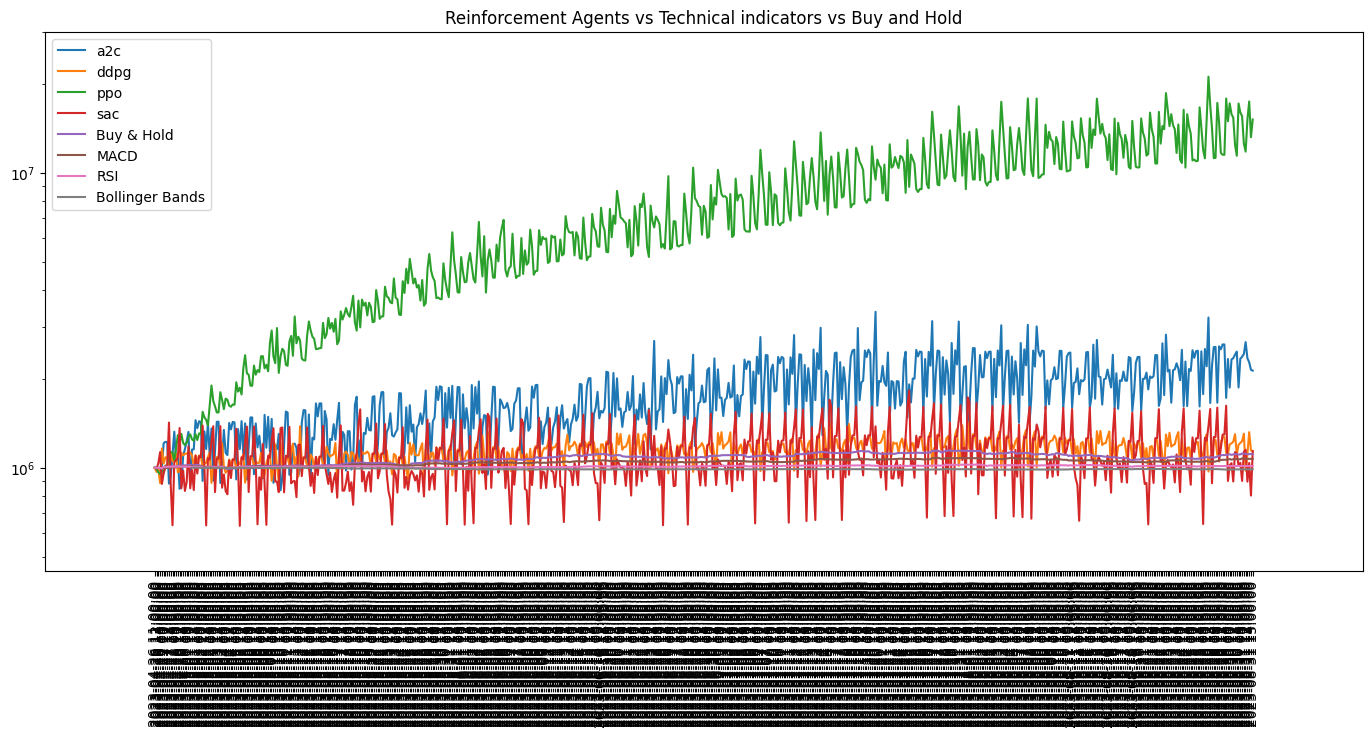

In [58]:
plt.figure(figsize=[17,7])
#https://stackoverflow.com/questions/9627686/plotting-dates-on-the-x-axis
#dates = result.index #'2023-04-26 11:00:00'
#x = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in dates]

plt.plot(result["a2c"], label = "a2c")
plt.plot(result["ddpg"], label = "ddpg")
plt.plot(result["ppo"], label = "ppo")
plt.plot(result["sac"], label = "sac")
plt.plot(buyandhold*capital, label = "Buy & Hold")
plt.plot(macd*capital, label = "MACD")
plt.plot(rsi*capital, label = "RSI")
plt.plot(bollinger*capital, label = "Bollinger Bands")
plt.yscale("log")
plt.xticks(rotation='vertical')
plt.margins(0.1)
plt.legend()

plt.title("Reinforcement Agents vs Technical indicators vs Buy and Hold")
plt.savefig("Technical Indicators.pdf")

In [93]:
df_account_value_a2c["date"]

0      2023-04-26 11:00:00
1      2023-04-26 12:00:00
2      2023-04-26 13:00:00
3      2023-04-26 14:00:00
4      2023-04-26 15:00:00
              ...         
616    2023-08-31 11:00:00
617    2023-08-31 12:00:00
618    2023-08-31 13:00:00
619    2023-08-31 14:00:00
620    2023-08-31 15:00:00
Name: date, Length: 621, dtype: object

In [78]:
from pyfolio import timeseries
perf_func = timeseries.perf_stats 

In [114]:
def backtest_pyfolio(model):
    perf_stats_all = perf_func(returns=pd.Series(model["account_value"].pct_change(1).values, index=model["date"]), 
                                  factor_returns=pd.Series(model["account_value"].pct_change(1).values, index=model["date"]), 
                                    positions=None, transactions=None, turnover_denom="AGB")
    print("==============DRL Stats Overview===========")
    print(perf_stats_all)

In [115]:
backtest_pyfolio(df_account_value_a2c)

==============DRL Stats Overview===========
Annual return          0.360302
Cumulative returns     1.134598
Annual volatility      4.375965
Sharpe ratio           2.278364
Calmar ratio           0.565699
Stability              0.530970
Max drawdown          -0.636915
Omega ratio            1.447469
Sortino ratio          3.703416
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.163014
Daily value at risk   -0.511756
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [116]:
#save the trades

df_actions_ppo.to_csv('trades_ppo.csv', index=True)

df_actions_a2c.to_csv('trades_a2c.csv', index=True)

df_actions_ddpg.to_csv('trades_ddpg.csv', index=True)

df_actions_td3.to_csv('trades_td3.csv', index=True)

df_actions_sac.to_csv('trades_sac.csv', index=True)